# Test PDPbox with binary classification problem
## Kaggle Titanic with XGBoost
This demo is based on **Titanic: Machine Learning from Disaster**  
https://www.kaggle.com/c/titanic/details/tutorials

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from pdpbox import pdp, get_dataset, info_plots

# get dataset and model

In [2]:
test_titanic = get_dataset.titanic()

In [3]:
test_titanic.keys()

['xgb_model', 'data', 'features', 'target']

In [4]:
titanic_data = test_titanic['data']
titanic_features = test_titanic['features']
titanic_model = test_titanic['xgb_model']
titanic_target = test_titanic['target']

# 1. Binary feature: Sex

## 1.1 target distribution through feature 'Sex'

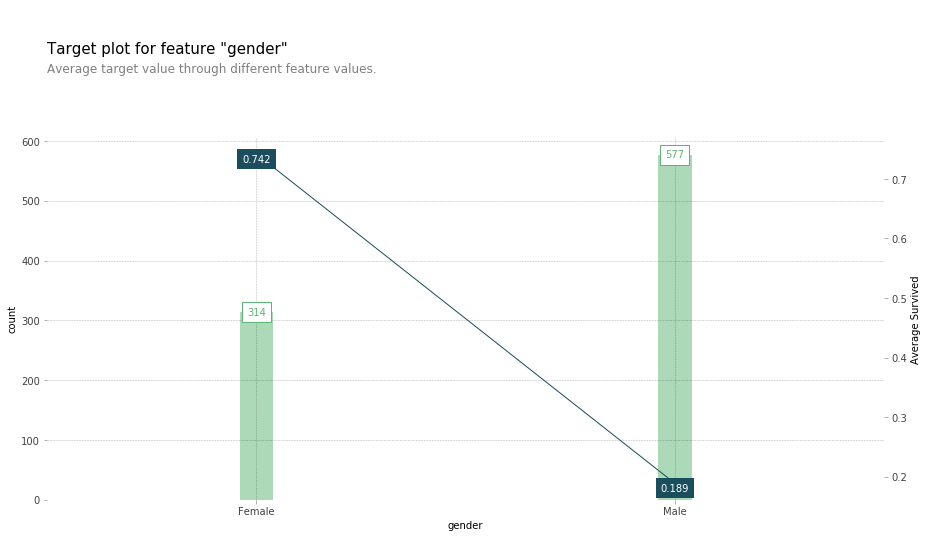

In [9]:
fig, axes, summary_df = info_plots.target_plot(df=titanic_data, 
                                               feature='Sex', 
                                               feature_name='gender',
                                               target=titanic_target)
_ = axes['bar_ax'].set_xticklabels(['Female', 'Male'])

In [10]:
summary_df

,x,display_column,count,Survived
0,0,Sex_0,314,0.742038
1,1,Sex_1,577,0.188908


## 1.2 check prediction distribution through feature 'Sex'

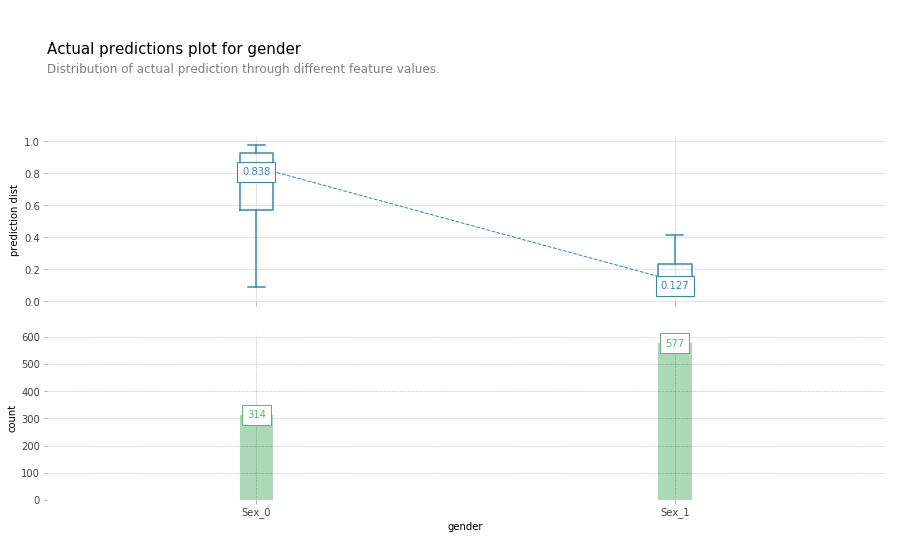

In [11]:
fig, axes, summary_df = info_plots.actual_plot(model=titanic_model, 
                                               X=titanic_data[titanic_features], 
                                               feature='Sex', 
                                               feature_name='gender')

In [12]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,Sex_0,314,0.567416,0.838413,0.927985
1,1,Sex_1,577,0.102959,0.126992,0.230747


## 1.3 pdp for feature 'Sex'

In [13]:
pdp_sex = pdp.pdp_isolate(model=titanic_model, 
                          dataset=titanic_data,
                          model_features=titanic_features,
                          feature='Sex')

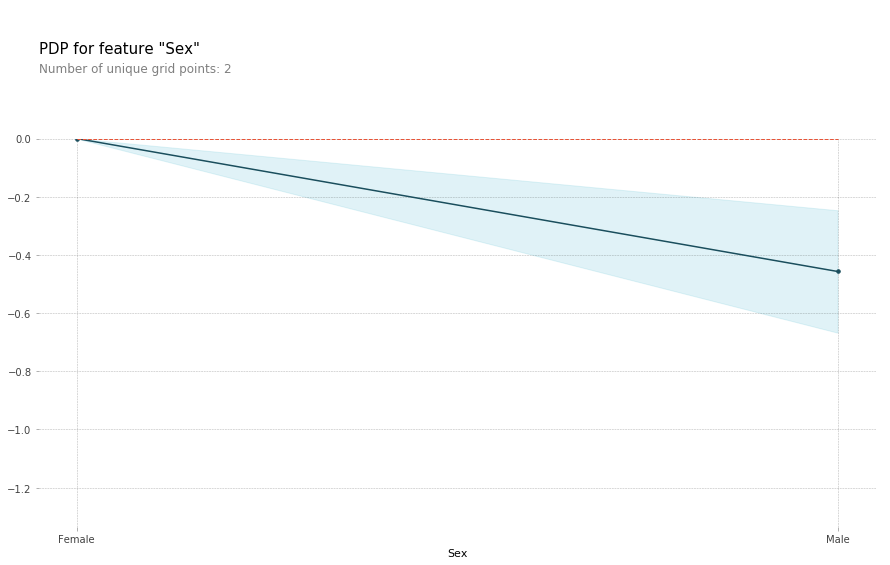

In [17]:
# default
fig, axes = pdp.pdp_plot(pdp_sex, 'Sex')
_ = axes['pdp_ax'].set_xticklabels(['Female', 'Male'])

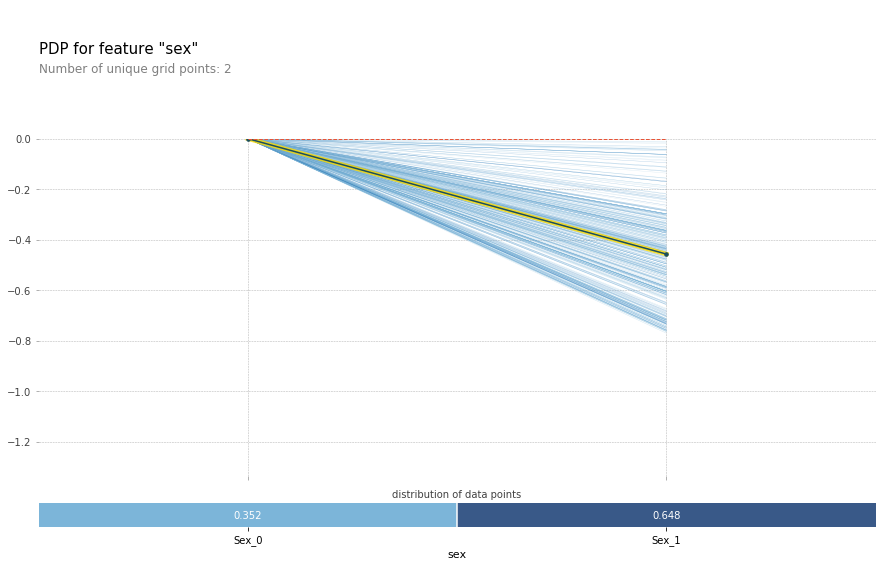

In [18]:
# more info
fig, axes = pdp.pdp_plot(pdp_sex, 'sex', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

# 2. one-hot encoding feature: embarked
for one-hot encoding feature, should provide a list containing all the related columns

## 2.1 target distribution through feature 'embarked'

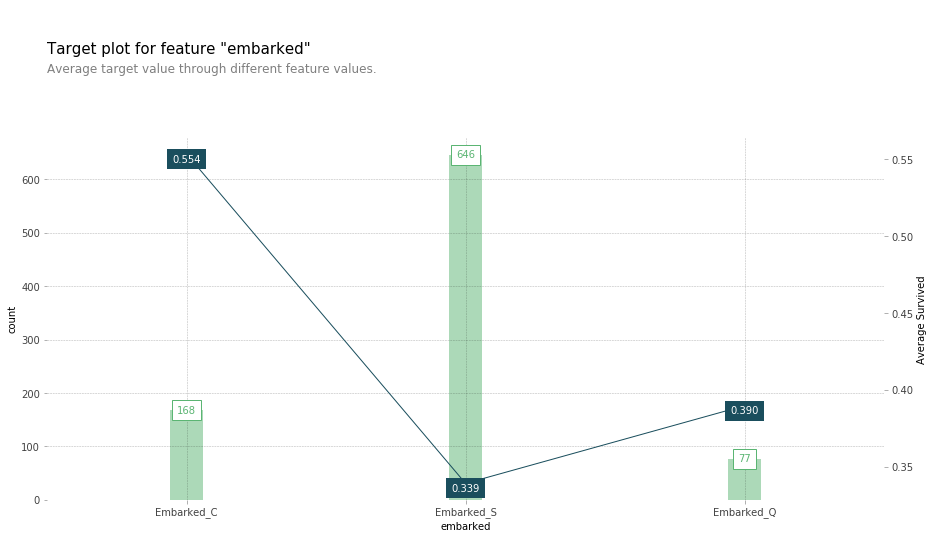

In [19]:
fig, axes, summary_df = info_plots.target_plot(df=titanic_data, 
                                               feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], 
                                               feature_name='embarked',
                                               target=titanic_target)

In [20]:
summary_df

,x,display_column,count,Survived
0,0,Embarked_C,168,0.553571
1,1,Embarked_S,646,0.339009
2,2,Embarked_Q,77,0.389610


## 2.2 check prediction distribution through feature 'embarked'

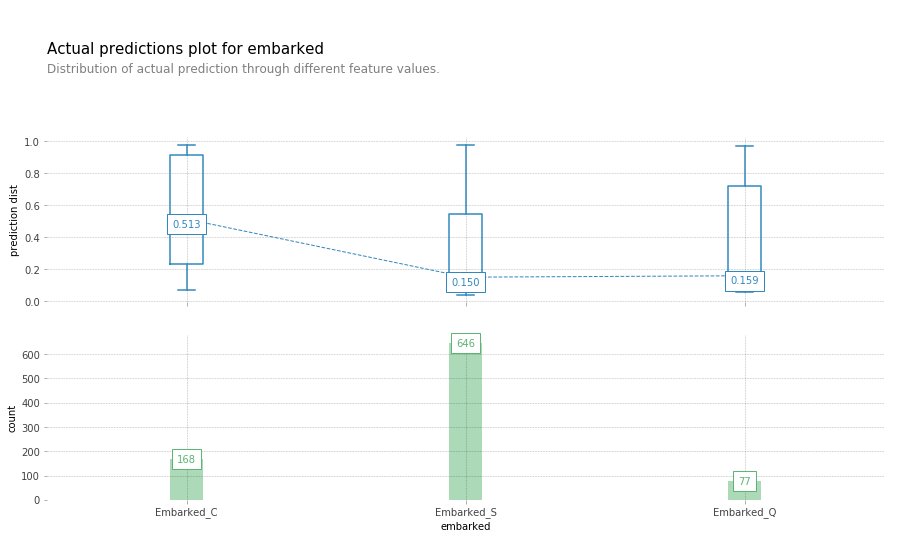

In [21]:
fig, axes, summary_df = info_plots.actual_plot(model=titanic_model, 
                                               X=titanic_data[titanic_features], 
                                               feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'], 
                                               feature_name='embarked')

In [22]:
summary_df

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,Embarked_C,168,0.231351,0.513156,0.912702
1,1,Embarked_S,646,0.109424,0.150355,0.545072
2,2,Embarked_Q,77,0.115931,0.159242,0.720176


## 2.3 pdp for feature 'embarked'

In [23]:
pdp_embark = pdp.pdp_isolate(model=titanic_model, 
                             dataset=titanic_data, 
                             model_features=titanic_features,
                             feature=['Embarked_C', 'Embarked_S', 'Embarked_Q'])

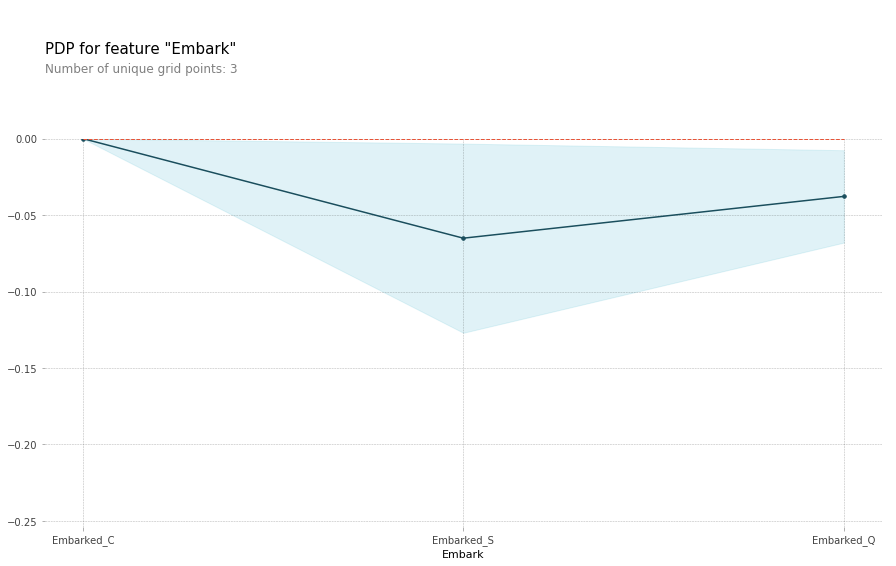

In [26]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark')

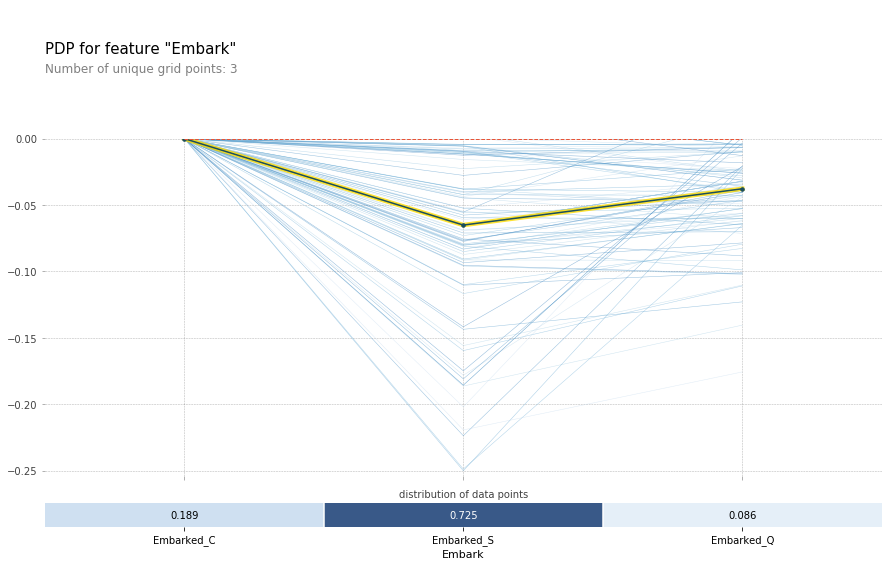

In [25]:
fig, axes = pdp.pdp_plot(pdp_embark, 'Embark', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

# 3. numeric feature: Fare

## 3.1 target distribution through feature 'Fare'

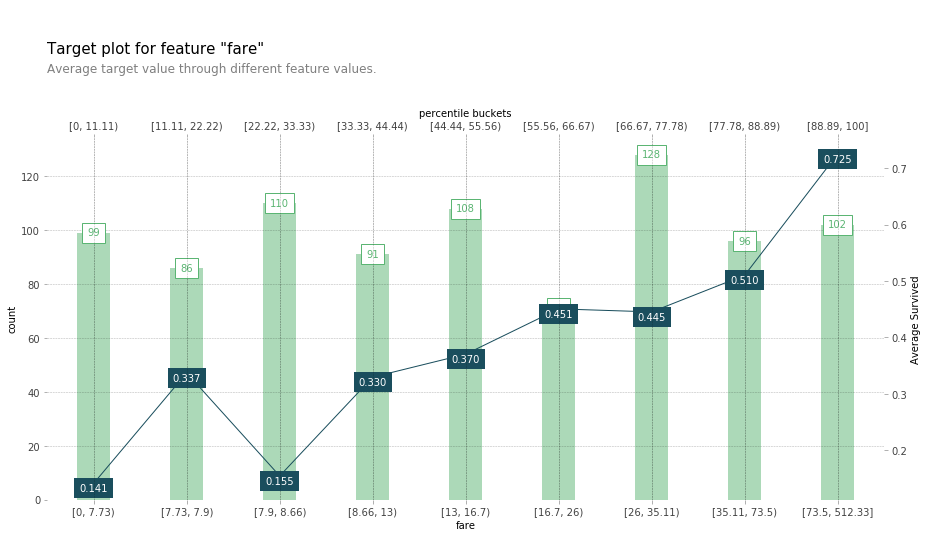

In [28]:
fig, axes, summary_df = info_plots.target_plot(df=titanic_data, 
                                               feature='Fare', 
                                               feature_name='fare',
                                               target=titanic_target, 
                                               show_percentile=True)

In [29]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,Survived
0,0,"[0, 7.73)",0.000000,7.732844,"[0, 11.11)",0.00,11.11,99,0.141414
1,1,"[7.73, 7.9)",7.732844,7.895800,"[11.11, 22.22)",11.11,22.22,86,0.337209
2,2,"[7.9, 8.66)",7.895800,8.662500,"[22.22, 33.33)",22.22,33.33,110,0.154545
3,3,"[8.66, 13)",8.662500,13.000000,"[33.33, 44.44)",33.33,44.44,91,0.329670
4,4,"[13, 16.7)",13.000000,16.700000,"[44.44, 55.56)",44.44,55.56,108,0.370370
5,5,"[16.7, 26)",16.700000,26.000000,"[55.56, 66.67)",55.56,66.67,71,0.450704
6,6,"[26, 35.11)",26.000000,35.111111,"[66.67, 77.78)",66.67,77.78,128,0.445312
7,7,"[35.11, 73.5)",35.111111,73.500000,"[77.78, 88.89)",77.78,88.89,96,0.510417
8,8,"[73.5, 512.33]",73.500000,512.329200,"[88.89, 100]",88.89,100.00,102,0.725490


## 3.2 check prediction distribution through feature 'Fare'

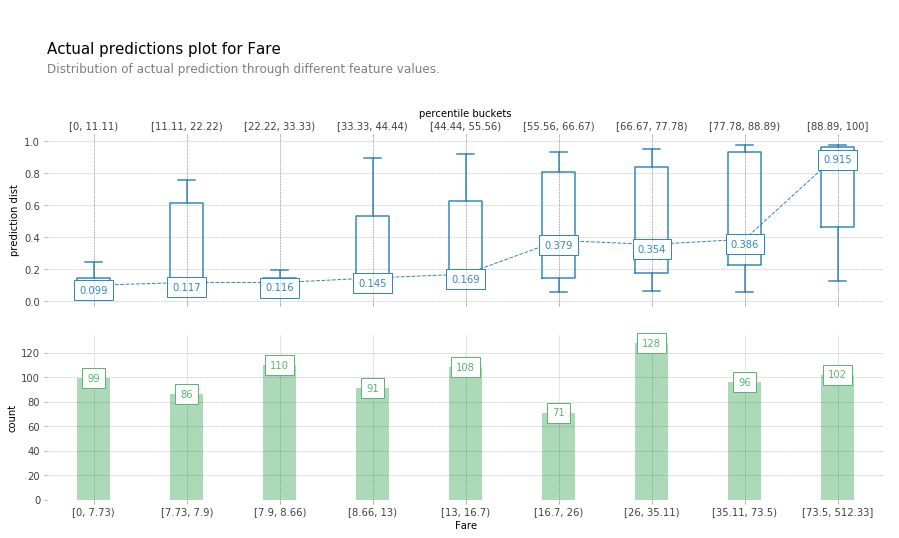

In [31]:
fig, axes, summary_df = info_plots.actual_plot(model=titanic_model, 
                                               X=titanic_data[titanic_features], 
                                               feature='Fare', 
                                               feature_name='Fare', 
                                               show_percentile=True)

In [32]:
summary_df

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[0, 7.73)",0.000000,7.732844,"[0, 11.11)",0.00,11.11,99,0.069861,0.099070,0.142362
1,1,"[7.73, 7.9)",7.732844,7.895800,"[11.11, 22.22)",11.11,22.22,86,0.107916,0.117240,0.614474
2,2,"[7.9, 8.66)",7.895800,8.662500,"[22.22, 33.33)",22.22,33.33,110,0.098939,0.116362,0.146534
3,3,"[8.66, 13)",8.662500,13.000000,"[33.33, 44.44)",33.33,44.44,91,0.114593,0.144842,0.530937
4,4,"[13, 16.7)",13.000000,16.700000,"[44.44, 55.56)",44.44,55.56,108,0.122154,0.168968,0.626364
5,5,"[16.7, 26)",16.700000,26.000000,"[55.56, 66.67)",55.56,66.67,71,0.146319,0.379385,0.805452
6,6,"[26, 35.11)",26.000000,35.111111,"[66.67, 77.78)",66.67,77.78,128,0.175587,0.353853,0.835547
7,7,"[35.11, 73.5)",35.111111,73.500000,"[77.78, 88.89)",77.78,88.89,96,0.223087,0.386497,0.929101
8,8,"[73.5, 512.33]",73.500000,512.329200,"[88.89, 100]",88.89,100.00,102,0.460539,0.914678,0.959526


## 3.3 pdp for feature 'Fare'

In [33]:
pdp_fare = pdp.pdp_isolate(model=titanic_model, 
                           dataset=titanic_data,
                           model_features=titanic_features, 
                           feature='Fare')

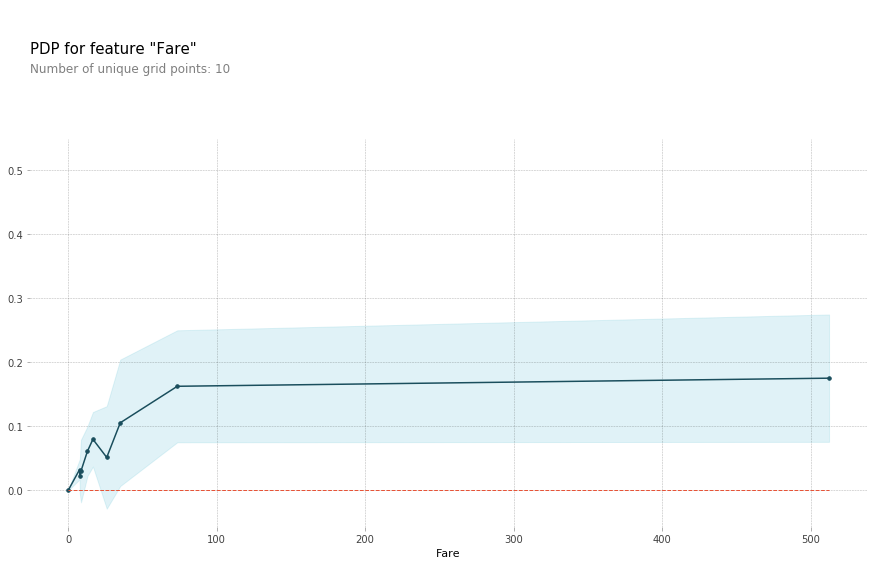

In [34]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare')

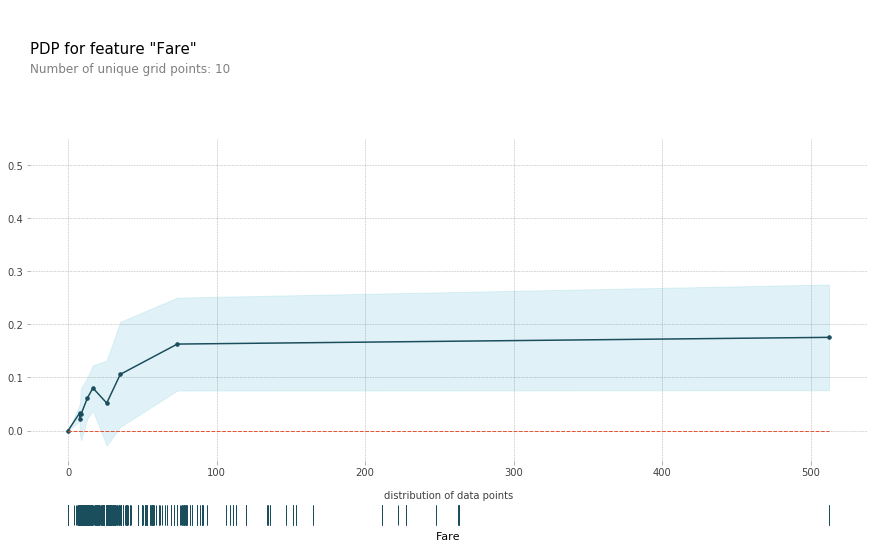

In [35]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare', plot_pts_dist=True)

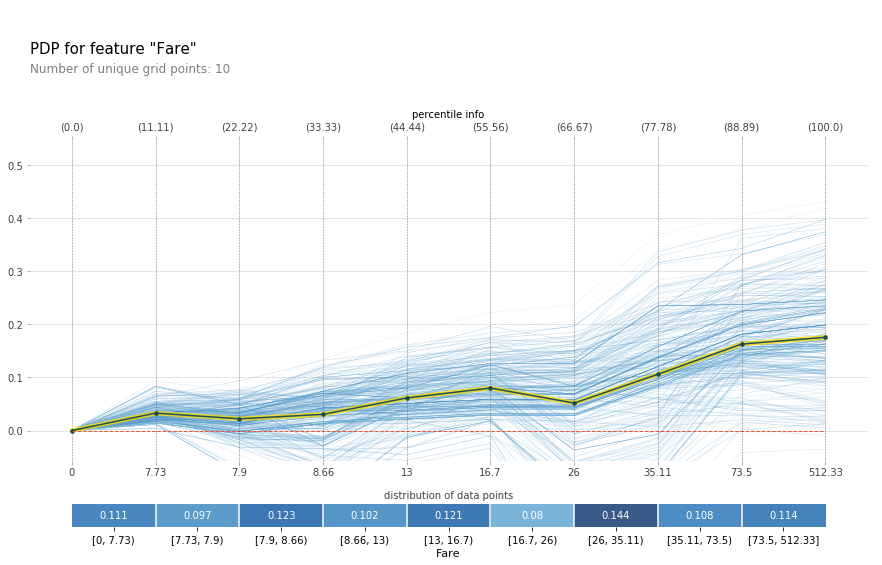

In [36]:
fig, axes = pdp.pdp_plot(pdp_fare, 'Fare', frac_to_plot=0.5, plot_lines=True,
                         x_quantile=True, show_percentile=True, plot_pts_dist=True)

# 4. Interaction between two variables: Age and Fare

## 4.1 target distribution through feature combination of 'Age' and 'Fare'

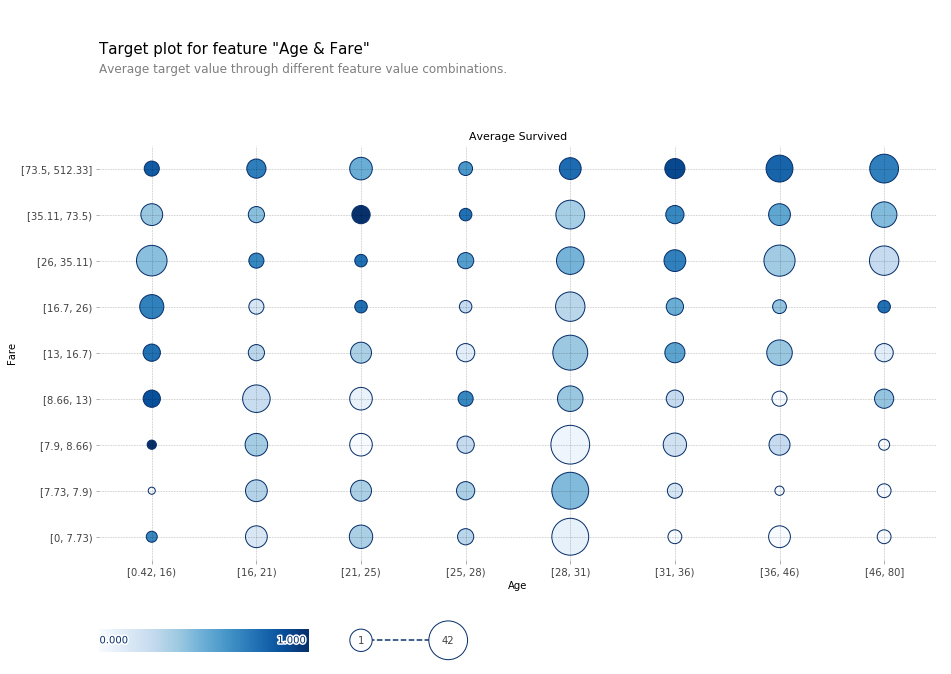

In [39]:
fig, axes, summary_df = info_plots.target_plot_interact(df=titanic_data, 
                                                        features=['Age', 'Fare'],
                                                        feature_names=['Age', 'Fare'], 
                                                        target=titanic_target, 
                                                        figsize=(15, 12))

In [41]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,value_lower_2,value_upper_2,count,Survived
0,0,0,"[0.42, 16)","[0, 7.73)",0.42,16.0,0.000000,7.732844,3,0.666667
1,0,1,"[0.42, 16)","[7.73, 7.9)",0.42,16.0,7.732844,7.895800,1,0.000000
2,0,2,"[0.42, 16)","[7.9, 8.66)",0.42,16.0,7.895800,8.662500,2,1.000000
3,0,3,"[0.42, 16)","[8.66, 13)",0.42,16.0,8.662500,13.000000,8,0.875000
4,0,4,"[0.42, 16)","[13, 16.7)",0.42,16.0,13.000000,16.700000,8,0.750000


## 4.2 prediction distribution through feature combination of 'Age' and 'Fare'

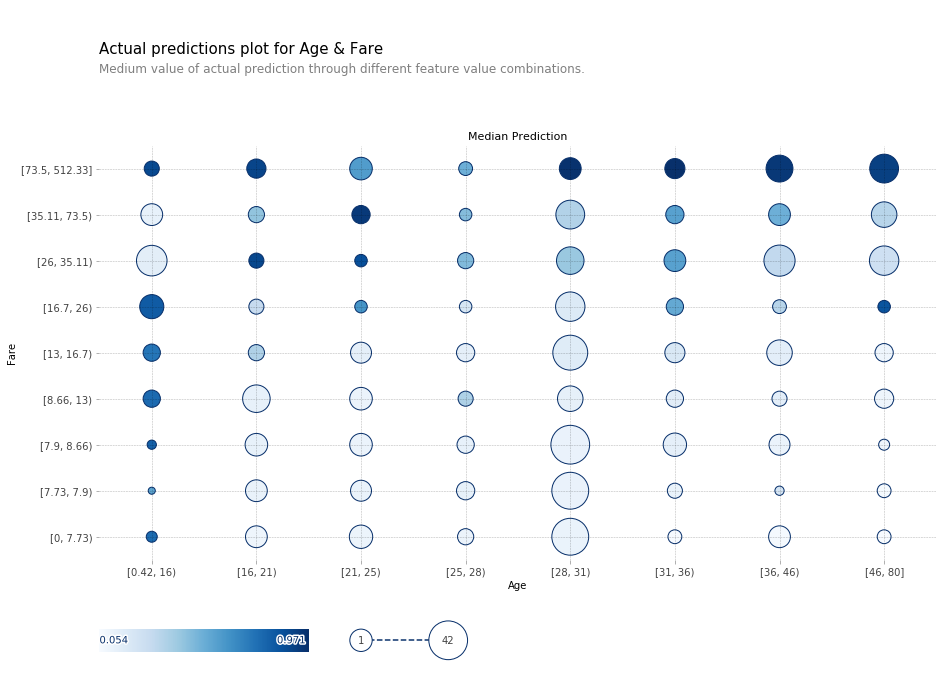

In [42]:
fig, axes, summary_df = info_plots.actual_plot_interact(model=titanic_model, 
                                                        X=titanic_data[titanic_features],
                                                        features=['Age', 'Fare'],
                                                        feature_names=['Age', 'Fare'], 
                                                        figsize=(15, 12))

In [43]:
summary_df.head()

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,value_lower_2,value_upper_2,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,0,"[0.42, 16)","[0, 7.73)",0.42,16.0,0.000000,7.732844,3,0.512765,0.759978,0.775501
1,0,1,"[0.42, 16)","[7.73, 7.9)",0.42,16.0,7.732844,7.895800,1,0.552150,0.552150,0.552150
2,0,2,"[0.42, 16)","[7.9, 8.66)",0.42,16.0,7.895800,8.662500,2,0.756839,0.799154,0.841470
3,0,3,"[0.42, 16)","[8.66, 13)",0.42,16.0,8.662500,13.000000,8,0.690055,0.764930,0.822442
4,0,4,"[0.42, 16)","[13, 16.7)",0.42,16.0,13.000000,16.700000,8,0.603621,0.724632,0.861933


## 4.3 pdp for feature combination of 'Age' and 'Fare'

In [45]:
inter1 = pdp.pdp_interact(model=titanic_model, 
                          dataset=titanic_data, 
                          model_features=titanic_features, 
                          features=['Age', 'Fare'])

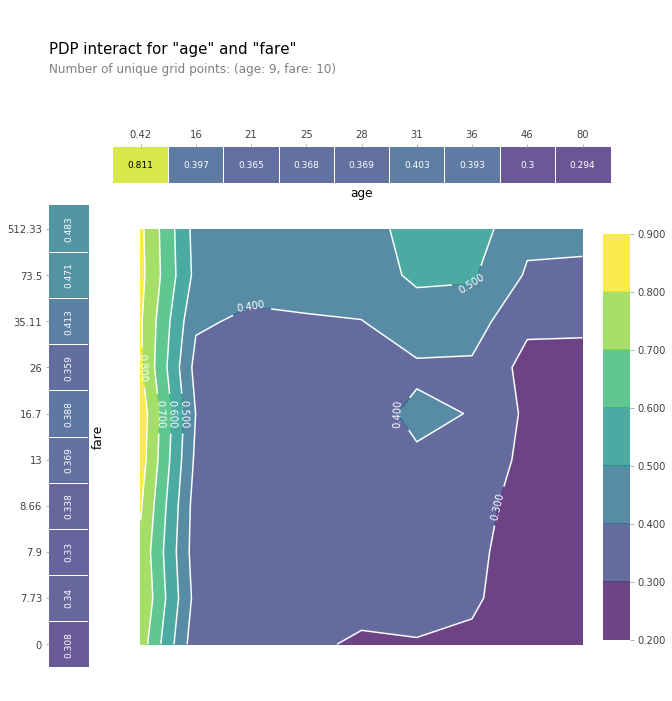

In [46]:
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                                  feature_names=['age', 'fare'], 
                                  plot_type='contour', 
                                  x_quantile=True, 
                                  plot_pdp=True)

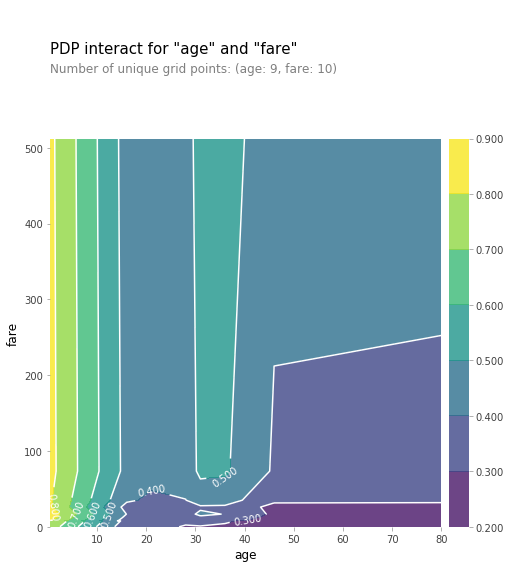

In [47]:
fig, axes = pdp.pdp_interact_plot(inter1, ['age', 'fare'], plot_type='contour', x_quantile=False, plot_pdp=False)

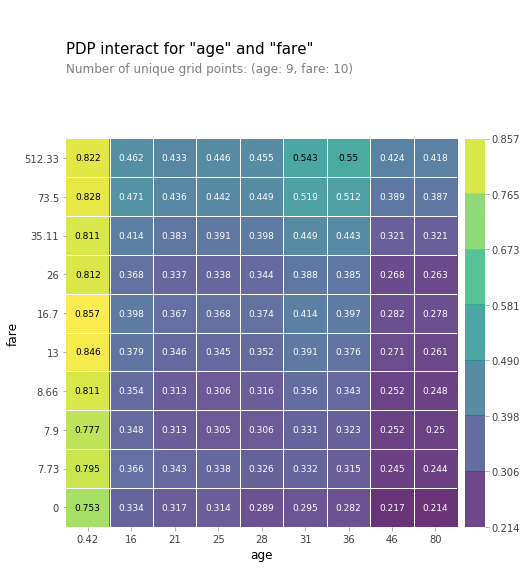

In [48]:
fig, axes = pdp.pdp_interact_plot(inter1, ['age', 'fare'], plot_type='grid', x_quantile=True, plot_pdp=False)